<a href="https://colab.research.google.com/github/mkuczynski11/iui-project/blob/master/IUI_project_bert_som.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notatnik do projektu z IUI - Klasyfikacja dokumentów prawnych z wizualizacją za pomocą algorytmu SOM

### Importowanie bibliotek i danych

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import re, string
import shutil

# model-building
from sklearn.model_selection import train_test_split

In [20]:
df = pd.read_csv('./drive/MyDrive/IUI/dbdata.csv', encoding='Windows-1250')
df.head()

,id,sample,label
0,0,czy wspólnota mieszkaniowa może podjąć uchwałę...,prawo cywilne
1,1,czy wspólnota mieszkaniowa może odzyskać pomie...,prawo cywilne
2,2,czy uprawnienie mieszkańców wspólnoty mieszkan...,prawo administracyjne
3,3,czy budowa windy dla osób niepełnosprawnych mo...,prawo administracyjne
4,4,jakie czynności powinna podjąć wspólnota miesz...,prawo cywilne


### Eksploracja danych

#### Dystybucja klas

[Text(0, 0, 'prawo cywilne'),
 Text(1, 0, 'prawo administracyjne'),
 Text(2, 0, 'prawo farmaceutyczne'),
 Text(3, 0, 'prawo pracy'),
 Text(4, 0, 'prawo medyczne'),
 Text(5, 0, 'prawo karne'),
 Text(6, 0, 'inne'),
 Text(7, 0, 'prawo podatkowe')]

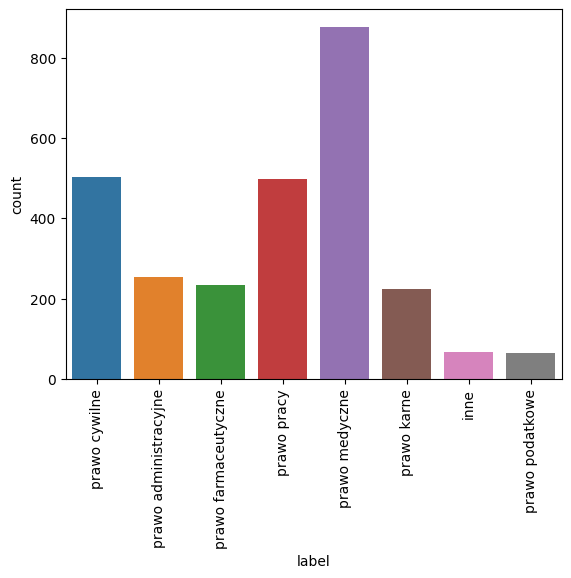

In [21]:
g = sns.countplot(x = 'label', data = df)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

#### Wartości brakujące

In [22]:
print(df.isna().sum())
print(f'Samples before cleanup: {len(df)}')
df = df[df['sample'].notnull()]
print(f'Samples after removing null sample values: {len(df)}')

id        0
sample    2
label     0
dtype: int64
Samples before cleanup: 2721
Samples after removing null sample values: 2719


### Wykorzystanie stworzonego modelu do tworzenia SOM

In [23]:
!pip install transformers
from transformers import *
!pip install transformers_interpret
from transformers_interpret import SequenceClassificationExplainer, MultiLabelClassificationExplainer
import torch

In [24]:
tuned_model = BertForSequenceClassification.from_pretrained("./drive/MyDrive/IUI/models/tuned_model_without_preprocess", num_labels=8)
tuned_model = tuned_model.to('cuda')
tokenizer = BertTokenizer.from_pretrained("dkleczek/bert-base-polish-cased-v1")

loading configuration file ./drive/MyDrive/IUI/models/tuned_model_without_preprocess/config.json
Model config BertConfig {
  "_name_or_path": "dkleczek/bert-base-polish-cased-v1",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--dkleczek--bert-base-polish-cased-v1/snapshots/fed744e81ebd16cf099b5c64c40688bc3e6ace67/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--dkleczek--bert-base-polish-cased-v1/snapshots/fed744e81ebd16cf099b5c64c40688bc3e6ace67/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--dkleczek--bert-base-polish-cased-v1/snapshots/fed744e81ebd16cf099b5c64c40688bc3e6ace67/tokenizer_config.json
loading file tokenizer.json from cache at None


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--dkleczek--bert-base-polish-cased-v1/snapshots/fed744e81ebd16cf099b5c64c40688bc3e6ace67/config.json
Model config BertConfig {
  "_name_or_path": "dkleczek/bert-base-polish-cased-v1",
  "architectures": [
    "BertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.34.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 60000
}



<!-- ### Przygotowanie danych do SOM -->

In [25]:
all_predictions = []
for index, row in df.iterrows():
  input = tokenizer(row['sample'], padding=True, truncation=True, return_tensors='pt', max_length=512).to('cuda')
  outputs = tuned_model(**input)
  predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
  predictions = predictions.cpu().detach().numpy()
  all_predictions.append(predictions[0])

all_predictions[:5]

[array([2.0252608e-03, 7.7149309e-03, 9.8486274e-01, 5.9290970e-04,
        2.1852236e-03, 9.3079486e-04, 1.0735082e-03, 6.1453530e-04],
       dtype=float32),
 array([2.5875645e-03, 2.7127784e-02, 9.6401346e-01, 6.0051779e-04,
        2.7237327e-03, 1.0172969e-03, 1.1699050e-03, 7.5974420e-04],
       dtype=float32),
 array([0.00551425, 0.8125782 , 0.17162137, 0.00081378, 0.00190521,
        0.00122833, 0.00394682, 0.00239201], dtype=float32),
 array([3.0242901e-03, 9.7525716e-01, 1.4567684e-02, 6.0193217e-04,
        1.1720844e-03, 4.8677804e-04, 2.1424801e-03, 2.7476666e-03],
       dtype=float32),
 array([2.5040065e-03, 2.1659106e-02, 9.6951532e-01, 4.5437232e-04,
        2.7824934e-03, 8.3730888e-04, 1.1574383e-03, 1.0899554e-03],
       dtype=float32)]

In [26]:
W = all_predictions
W = (W - np.mean(W, axis=0)) / np.std(W, axis=0)
W[0]

array([-0.22542161, -0.31596038,  2.1408572 , -0.331204  , -0.32319236,
       -0.7430157 , -0.1751061 , -0.5020266 ], dtype=float32)

### Self Organising Map dokumentów z minisom DONE

In [27]:
!pip install minisom
from minisom import MiniSom

In [28]:
import math
n_neurons = 16 # 5*math.sqrt(len(W))
m_neurons = 16 # 5*math.sqrt(len(W))
som = MiniSom(x=n_neurons, y=m_neurons, input_len=len(W[0]), sigma=2.0, learning_rate=0.5, neighborhood_function='gaussian', topology='rectangular', activation_distance='euclidean', random_seed=5)
# som.pca_weights_init(W)
som.train_batch(W, len(W)*10, verbose=True)

 [ 27190 / 27190 ] 100% - 0:00:00 left 
 quantization error: 0.07745677043719018


In [29]:
som_x = []
som_y = []
for i in range(len(W)):
  w = som.winner(W[i])
  som_x.append(w[0])
  som_y.append(w[1])

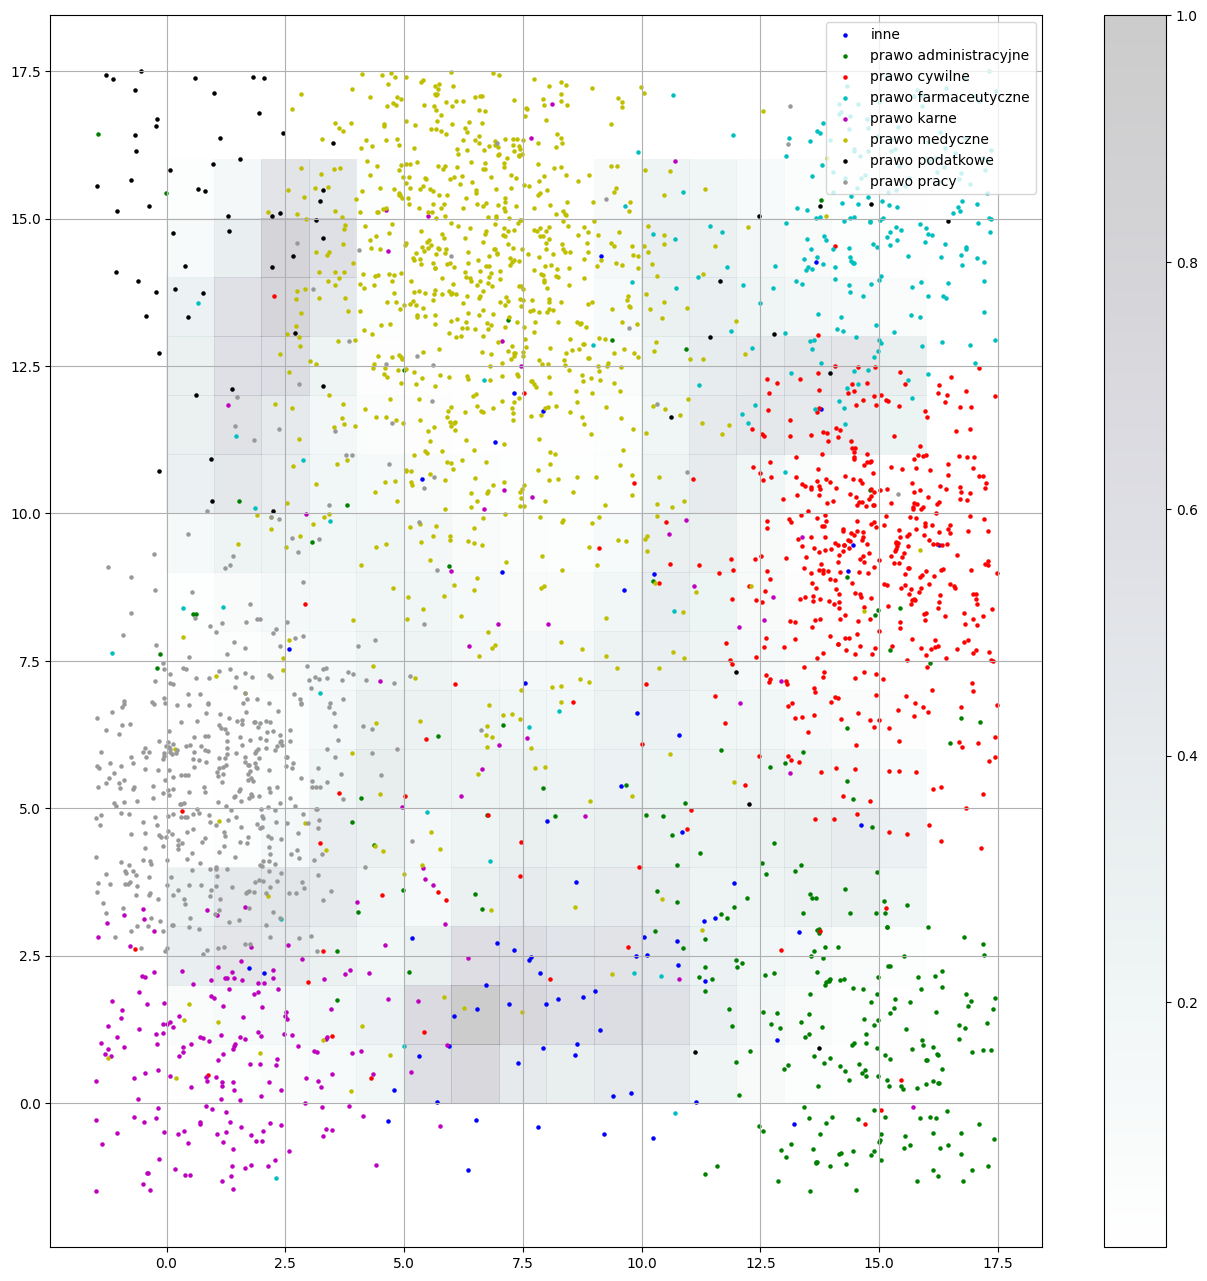

In [30]:
import matplotlib.pyplot as plt
plt.figure(figsize=(n_neurons,m_neurons))

plt.pcolor(som.distance_map().T, cmap='bone_r', alpha=.2)
plt.colorbar()

target = df['label'].values
w_x = np.array(som_x)
w_y = np.array(som_y)
colors = {
    'inne': 'b',
    'prawo administracyjne': 'g',
    'prawo cywilne': 'r',
    'prawo farmaceutyczne': 'c',
    'prawo karne': 'm',
    'prawo medyczne': 'y',
    'prawo podatkowe': 'k',
    'prawo pracy': '0.6'
}
for c in np.unique(target):
  idx_target = target == c
  plt.scatter(w_x[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*4.0,
              w_y[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*4.0,
              s=5, c=colors[c], label=c)
plt.legend(loc='upper right')
plt.grid()
plt.savefig('som_documents.png')
plt.show()
# df.head(40)

### Zamiana dokumentów na najważniejsze słowa

In [31]:
cls_explainer = SequenceClassificationExplainer(tuned_model, tokenizer)

In [32]:
# df['clean_sample'][0]
df['sample'][0]

'czy wspólnota mieszkaniowa może podjąć uchwałę dotyczącą zakupu wodomierzy odczytywanych radiowo do lokali pokrywając ich koszty'

In [33]:
cls_explainer(df['sample'][0])

[('[CLS]', 0.0),
 ('czy', 0.04950865176068623),
 ('wspólnota', 0.4398901807022435),
 ('mieszkani', 0.5305189236679104),
 ('##owa', 0.12091931844736312),
 ('może', 0.036807561940766266),
 ('podjąć', 0.12183821445429142),
 ('uchwałę', 0.45249031689718633),
 ('dotyczącą', 0.08555746488458225),
 ('zakupu', 0.18414643634584557),
 ('wodo', 0.2132744812867281),
 ('##mierzy', 0.12519526221169897),
 ('odczyty', 0.03643036328383797),
 ('##wanych', -0.04550965922951801),
 ('radiowo', 0.0109880074632414),
 ('do', 0.10769532492615332),
 ('lokali', 0.24779819256390706),
 ('pokrywają', 0.16515203330189474),
 ('##c', 0.035443490231029696),
 ('ich', 0.12782189177950992),
 ('koszty', 0.2514873662442981),
 ('[SEP]', 0.0)]

In [34]:
# Ta funkcja zajmuje strasznie długo czasu, można ją usprawnić
texts = []
for index, row in df.iterrows():
  words = cls_explainer(row['sample'])
  word = max(words, key=lambda x: x[1])
  texts.append(word)

In [35]:
texts[0]

('mieszkani', 0.5305189236679104)

<ipython-input-36-498bcc628453>:30: UserWarning: Legend does not support handles for Text instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='upper right')


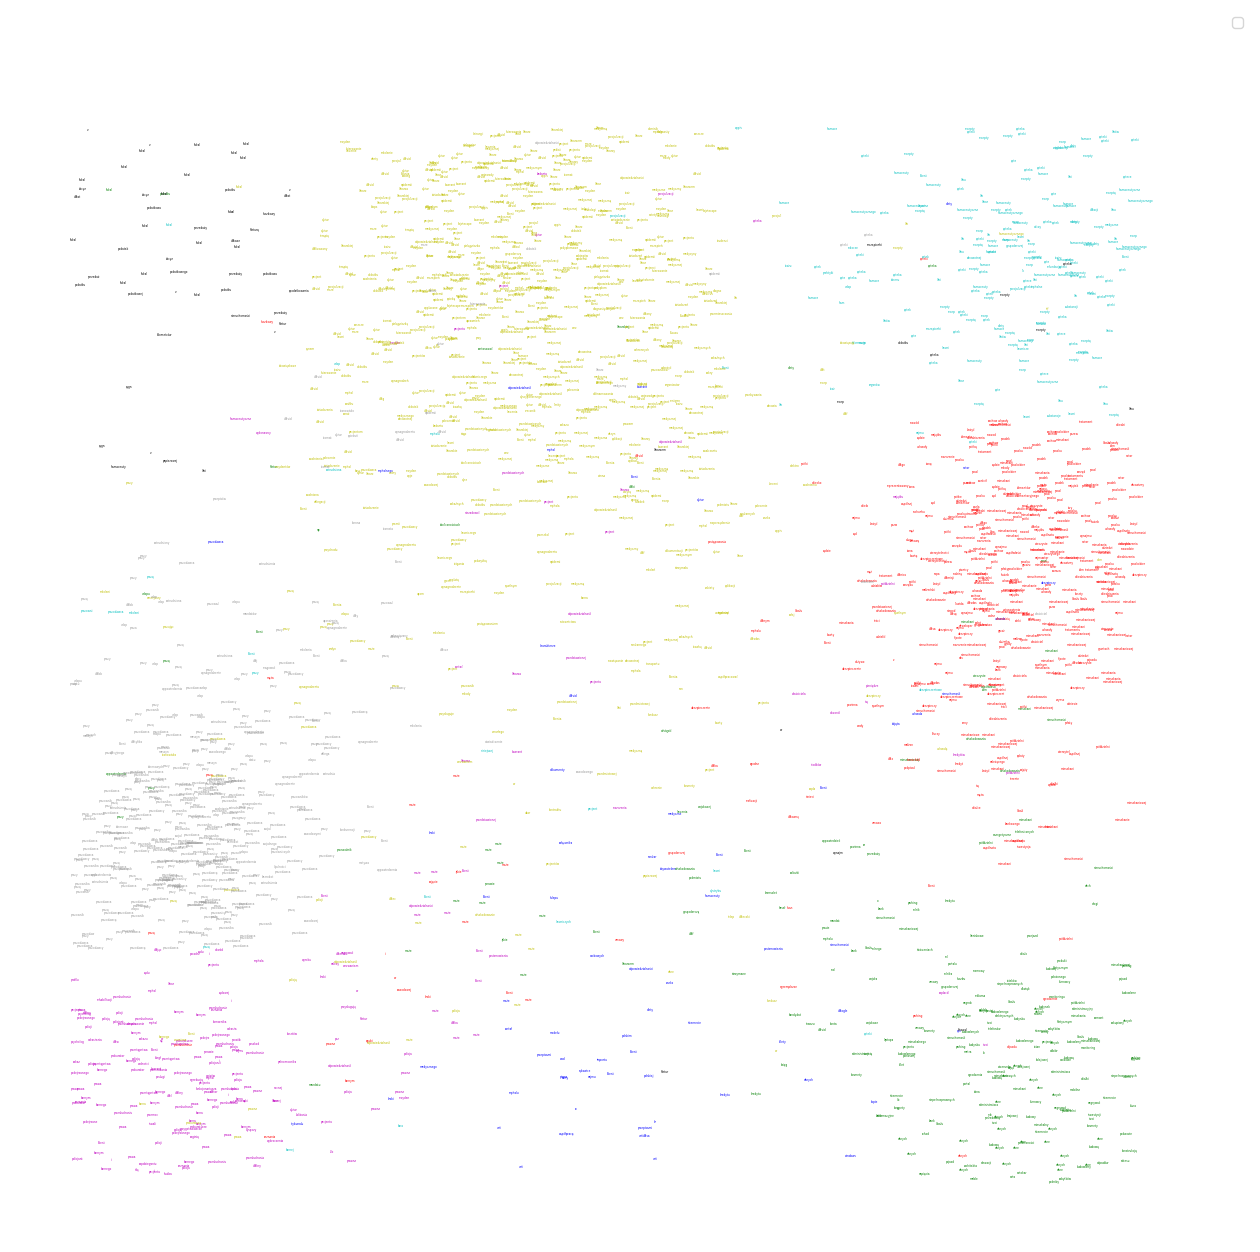

In [36]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(n_neurons,m_neurons))

# plt.pcolor(som.distance_map().T, cmap='bone_r', alpha=.2)
# plt.colorbar()

target = df['label'].values
w_x = np.array(som_x)
w_y = np.array(som_y)
colors = {
    'inne': 'b',
    'prawo administracyjne': 'g',
    'prawo cywilne': 'r',
    'prawo farmaceutyczne': 'c',
    'prawo karne': 'm',
    'prawo medyczne': 'y',
    'prawo podatkowe': 'k',
    'prawo pracy': '0.6'
}

for c in np.unique(target):
  idx_target = target == c
  for i in range(len(idx_target)):
    if (idx_target[i] == False): continue
    plt.text(w_x[i]+.5+(np.random.rand()-.5)*3.0,
             w_y[i]+.5+(np.random.rand()-.5)*3.0,
             s=texts[i][0], c=colors[c], label=c, fontsize=2, verticalalignment='center')


plt.legend(loc='upper right')
plt.grid(False)
plt.axis('off')
plt.xlim([-2, 19])
plt.ylim([-2, 19])
fig.savefig('temp.png', dpi=300)